<a href="https://colab.research.google.com/github/avyaymc/Convolutional-Visual-Prompts/blob/main/contrastive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!pip install tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D


#Data

In [ ]:
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CIFAR10C(Dataset):
    def __init__(self, corruption_npy, labels_npy, transform=None):
        self.images = np.load(corruption_npy)
        self.labels = np.load(labels_npy)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
data_folder = "/content/drive/MyDrive/CIFAR-10-C/"

labels_npy = f"{data_folder}/labels.npy"

corruption_file = "fog.npy"


corruption_npy = f"{data_folder}/{corruption_file}"

te= np.load(corruption_npy)
shape=te.shape
print("shape:", shape)
corruption_name = corruption_file[:-4]
datasets = {corruption_name: CIFAR10C(corruption_npy, labels_npy, transform=ToTensor())}

# Save the fine-tuned model
#model_path = '/content/drive/MyDrive/resnet18_cifar10_finetuned.pth'
#torch.save(resnet18_cifar10.state_dict(), model_path)


Mounted at /content/drive
shape: (50000, 32, 32, 3)


In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (_, _) = cifar10.load_data()
severity_level = 1
filtered_indices = np.where(y_train[:, 0] == severity_level)[0][:10000]
x_filtered = x_train[filtered_indices]


170498071/170498071 [==============================] - 16s 0us/step


In [ ]:
num_images_to_visualize = 5
random_indices = np.random.choice(range(len(x_filtered)), num_images_to_visualize, replace=False)


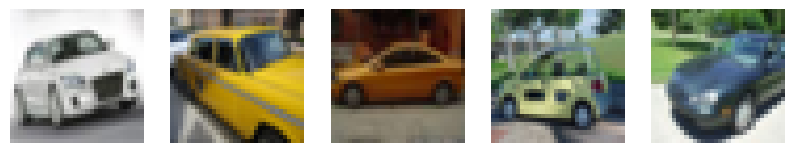

In [ ]:


plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_visualize, i+1)
    plt.imshow(x_filtered[idx])
    plt.axis('off')
plt.show()


#models

The only difference being the absence of the self supervised model and using contrastive loss alone


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
model_save_path = "/content/drive/MyDrive/resnet18_cifar10_finetuned.pth"
#model_save_path = '/content/drive/MyDrive/resnet18_cifar10_c_finetuned.pth'

def resnet18_cifar():
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model.fc = nn.Linear(512, 10)
    return model


resnet18_cifar10 = resnet18_cifar().to(device)


resnet18_cifar10.load_state_dict(torch.load(model_save_path))
#resnet18_cifar10.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


<All keys matched successfully>

In [ ]:
import torch.nn.functional as F
def contrastive_loss(z, y, tau=0.1, epsilon=1e-8):
    z = F.normalize(z, dim=1)
    cos_sim = torch.matmul(z, z.T) / (torch.norm(z, dim=1).unsqueeze(1) * torch.norm(z, dim=1).unsqueeze(0) + epsilon)

    mask = (y.unsqueeze(1) == y.unsqueeze(0)).float()
    mask.fill_diagonal_(0)

    cos_sim_max = torch.max(cos_sim, dim=1, keepdim=True)[0]
    cos_sim_exp = torch.exp((cos_sim - cos_sim_max) / tau)
    cos_sim_exp_sum = cos_sim_exp.sum(1) - torch.diag(cos_sim_exp)
    cos_sim_exp_sum_positive = torch.sum(cos_sim_exp * mask, dim=1)

    loss = torch.log(cos_sim_exp_sum + epsilon) - torch.log(cos_sim_exp_sum_positive + epsilon)
    loss = loss.mean()

    return loss


In [ ]:
class ResNetFeatures(nn.Module):
    def __init__(self, original_model, layer_index):
        super(ResNetFeatures, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.layer_index = layer_index

    def forward(self, x):
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == self.layer_index:
                break
        return x


In [ ]:
def get_last_conv_layer(module):
    if isinstance(module, nn.Conv2d):
        return module
    elif isinstance(module, nn.Sequential) or isinstance(module, nn.Module):
        children = list(module.children())
        for child in reversed(children):
            result = get_last_conv_layer(child)
            if result is not None:
                return result
    return None

layer_index = len(list(resnet18_cifar10.children())) - 2
last_conv_layer = get_last_conv_layer(resnet18_cifar10)

layer_input_channels = last_conv_layer.out_channels if last_conv_layer is not None else None

resnet18_cifar10_features = ResNetFeatures(resnet18_cifar10, layer_index)
print("Last layer output channels:", layer_input_channels)


Last layer output channels: 512


In [ ]:
with torch.no_grad():
    sample_input = torch.randn(1, 3, 32, 32).to(device)
    sample_output = resnet18_cifar10_features(sample_input)
    feature_shape = sample_output.shape[1:]
    feature_dim = torch.prod(torch.tensor(feature_shape)).item()
    print("Feature shape:", feature_shape)
    print("Feature dim:", feature_dim)

Feature shape: torch.Size([512, 1, 1])
Feature dim: 512


In [ ]:
class ConvKernel(nn.Module):
    def __init__(self, kernel_size, in_channels, out_channels):
        super(ConvKernel, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResNetClassifier(nn.Module):
    def __init__(self, original_model):
        super(ResNetClassifier, self).__init__()
        self.classifier = nn.Sequential(*list(original_model.children())[-1:])

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
resnet18_cifar10_classifier = ResNetClassifier(resnet18_cifar10).to(device)

#training

In [ ]:
def train_conv_kernel(dataloader, model, classifier, device, learning_rate, contrastive_loss_fn, kernel_optimization_steps=1500):
    model.eval()
    classifier.eval()

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        conv_kernel_module = ConvKernel(kernel_size=3,
                                in_channels=layer_input_channels,
                                out_channels=layer_input_channels).to(device)

        # Initialize the kernel parameters from a uniform distribution
        for param in conv_kernel_module.parameters():
            param.data.uniform_(-1.0, 1.0)

        optimizer = torch.optim.SGD(conv_kernel_module.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)

        with torch.no_grad():
            features = model(inputs)
        initial_loss = contrastive_loss_fn(features.view(features.size(0), -1), labels)

        # Save the initial state of the convolutional kernel
        initial_state_dict = conv_kernel_module.state_dict()

        for t in range(kernel_optimization_steps):
            optimizer.zero_grad()

            prompted_features = conv_kernel_module(features)

            prompted_features_flattened = prompted_features.view(prompted_features.size(0), -1)

            loss = contrastive_loss_fn(prompted_features_flattened, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(conv_kernel_module.parameters(), 1.0)
            optimizer.step()

            if t == kernel_optimization_steps - 1:
                final_loss = loss.item()

        # If the final loss is greater than the initial loss, use the initial kernel parameters
        if final_loss > initial_loss.item():
            conv_kernel_module.load_state_dict(initial_state_dict)

        prompted_features = conv_kernel_module(features)
        prompted_features_flattened = prompted_features.view(prompted_features.size(0), -1)

        outputs = classifier(prompted_features_flattened)

        _, predicted_labels = torch.max(outputs, 1)
        correct = (predicted_labels == labels).sum().item()
        accuracy = 100 * correct / labels.size(0)

        print(f'Batch [{i + 1}/{len(dataloader)}], Loss: {final_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [ ]:
learning_rate = 0.001
batch_size = 25
accumulation_steps = 4
corrupted_dataloader = torch.utils.data.DataLoader(datasets['fog'], batch_size=batch_size, shuffle=True, num_workers=2)
projection_dim = 512

# Load the entire dataset
full_dataset = CIFAR10C(corruption_npy, labels_npy, transform=ToTensor())

# Create a subset for severity 1
severity1_dataset = torch.utils.data.Subset(full_dataset, range(10000))

# Create a DataLoader for the subset
severity1_dataloader = torch.utils.data.DataLoader(severity1_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model on the DataLoader
train_conv_kernel(severity1_dataloader, resnet18_cifar10_features, resnet18_cifar10_classifier, device, learning_rate, contrastive_loss)


#train_conv_kernel(corrupted_dataloader, resnet18_cifar10_features, resnet18_cifar10_classifier, device, learning_rate, contrastive_loss)


In [ ]:
from torchvision.datasets import CIFAR10

# Define the transform
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load the non-corrupted CIFAR10 dataset
non_corrupted_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the non-corrupted dataset
non_corrupted_dataloader = torch.utils.data.DataLoader(non_corrupted_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model on the DataLoader
train_conv_kernel(non_corrupted_dataloader, resnet18_cifar10_features, resnet18_cifar10_classifier, device, learning_rate, contrastive_loss)


In [ ]:
def evaluate_model(dataloader, model, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted_labels = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()

            batch_accuracy = 100 * correct / total
            print(f'Batch [{i + 1}/{len(dataloader)}], Accuracy: {batch_accuracy:.2f}%')

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')


evaluate_model(corrupted_dataloader, resnet18_cifar10, device)


Batch [1/2000], Accuracy: 36.00%
Batch [2/2000], Accuracy: 40.00%
Batch [3/2000], Accuracy: 41.33%
Batch [4/2000], Accuracy: 38.00%
Batch [5/2000], Accuracy: 41.60%
Batch [6/2000], Accuracy: 46.00%
Batch [7/2000], Accuracy: 43.43%
Batch [8/2000], Accuracy: 45.00%
Batch [9/2000], Accuracy: 44.89%
Batch [10/2000], Accuracy: 44.80%
Batch [11/2000], Accuracy: 46.91%
Batch [12/2000], Accuracy: 47.33%
Batch [13/2000], Accuracy: 46.15%
Batch [14/2000], Accuracy: 46.29%
Batch [15/2000], Accuracy: 46.40%
Batch [16/2000], Accuracy: 47.25%
Batch [17/2000], Accuracy: 47.06%
Batch [18/2000], Accuracy: 48.22%
Batch [19/2000], Accuracy: 48.21%
Batch [20/2000], Accuracy: 47.80%
Batch [21/2000], Accuracy: 47.24%
Batch [22/2000], Accuracy: 46.55%
Batch [23/2000], Accuracy: 46.09%
Batch [24/2000], Accuracy: 46.33%
Batch [25/2000], Accuracy: 46.24%
Batch [26/2000], Accuracy: 46.92%
Batch [27/2000], Accuracy: 46.96%
Batch [28/2000], Accuracy: 47.71%
Batch [29/2000], Accuracy: 47.86%
Batch [30/2000], Accura

KeyboardInterrupt: ignored